In [1]:
import os
import sys
project_dir = os.path.abspath('../')
sys.path.append(project_dir)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from envs import CartPoleSwingUpWarpEnv
env = CartPoleSwingUpWarpEnv(num_envs=1)

Using cached kernels


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/networkx/classes/graph.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, Set, Iterable
/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.in

Warp initialized:
   Version: 0.4.3
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA GeForce RTX 3090
   Kernel cache: /home/ksrini/.cache/warp/0.4.3


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/urdfpy/urdf.py:898: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  value = np.asanyarray(value).astype(np.float)


In [4]:
def test_fn(actions, plot=False):
    ob_vec = []
    ob_vec.append(env.reset().detach().cpu().numpy().flatten())
    for _ in range(20):
        obs, reward, done, info = env.step(actions)
        ob_vec.append(obs.detach().cpu().numpy().flatten())
    if plot:
        ob_vec = np.array(ob_vec)
        fig, axs = plt.subplots(nrows=1, ncols=ob_vec.shape[1], figsize=(3*ob_vec.shape[1], 4))
        for i in range(ob_vec.shape[1]):
            axs[i].plot(ob_vec[:, i])
            axs[i].grid()
        plt.suptitle('without IK')
        plt.show()
    return reward


def check_grad(fn, inputs, eps=1e-6, atol=1e-4, rtol=1e-6, reward):
    out = fn(inputs)
    out.backward()
    analytical = inputs.grad.clone()
    x2, x1 = inputs + eps, inputs - eps
    numerical = (fn(x2) - fn(x1)) / (2 * eps)
    assert torch.allclose(numerical, analytical, rtol, atol), "numerical gradient was: {}, analytical was: {}".format(numerical, analytical)
    return (numerical, analytical)

Module utils.warp_utils load on device 'cuda:0' took 0.35 ms
Module warp.sim.articulation load on device 'cuda:0' took 0.80 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 1.88 ms


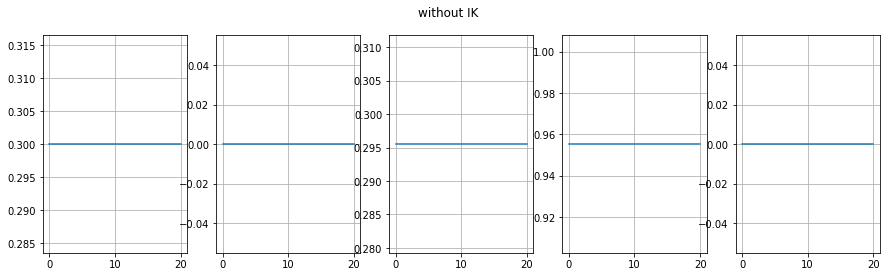

tensor([-0.0945], device='cuda:0', grad_fn=<SubBackward0>)

In [5]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
test_fn(action, plot=True)

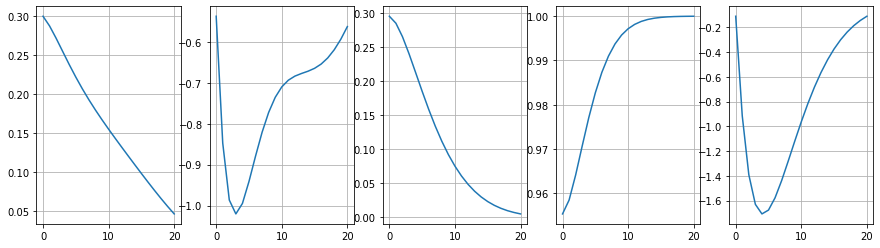

tensor([-0.0330], device='cuda:0', grad_fn=<SubBackward0>)

In [11]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
test_fn(action, plot=True)

In [17]:
obs = env.reset()

env.step(action)

(tensor([[ 0.0000e+00,  0.0000e+00,  8.7423e-08, -1.0000e+00,  0.0000e+00]],
        device='cuda:0', grad_fn=<CatBackward0>),
 tensor([-9.8696], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([0], device='cuda:0'),
 {})

In [14]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
a2 = torch.tensor([[0.5]], requires_grad=True, device='cuda')
a2 = torch.tensor([[0.75]], requires_grad=True, device='cuda')

In [16]:
test_fn(a2)

tensor([-9.8696], device='cuda:0', grad_fn=<SubBackward0>)

In [15]:
check_grad(test_fn, a2)

(tensor([0.], device='cuda:0', grad_fn=<DivBackward0>),
 tensor([[0.]], device='cuda:0'))

In [17]:
rew = test_fn(action)

particle_q
particle_qd
particle_mass
particle_inv_mass
shape_geo_scale
shape_contact_thickness
spring_rest_length
spring_stiffness
spring_damping
spring_control
tri_activations
tri_materials
edge_rest_angle
edge_bending_properties
tet_activations
tet_materials
body_com
joint_axis
joint_armature
joint_target_ke
joint_target_kd
joint_target
joint_linear_compliance
joint_angular_compliance
joint_limit_lower
joint_limit_upper
particle_q_original
muscle_params
muscle_points
muscle_activation
body_mass
body_inv_mass
joint_limit_ke
joint_limit_kd
soft_contact_body_pos
soft_contact_body_vel
soft_contact_normal
rigid_contact_point0
rigid_contact_point1
rigid_contact_offset0
rigid_contact_offset1
rigid_contact_normal
rigid_contact_thickness
rigid_active_contact_point0
rigid_active_contact_point1
rigid_active_contact_distance
rigid_active_contact_distance_prev
rigid_contact_inv_weight


tensor([-11.4972], device='cuda:0', grad_fn=<SubBackward0>)

In [18]:
Out[17].backward()

In [25]:
model_vars = """particle_q
particle_qd
particle_mass
particle_inv_mass
shape_geo_scale
shape_contact_thickness
spring_rest_length
spring_stiffness
spring_damping
spring_control
tri_activations
tri_materials
edge_rest_angle
edge_bending_properties
tet_activations
tet_materials
body_com
joint_axis
joint_armature
joint_target_ke
joint_target_kd
joint_target
joint_linear_compliance
joint_angular_compliance
joint_limit_lower
joint_limit_upper
particle_q_original
muscle_params
muscle_points
muscle_activation
body_mass
body_inv_mass
joint_limit_ke
joint_limit_kd
soft_contact_body_pos
soft_contact_body_vel
soft_contact_normal
rigid_contact_point0
rigid_contact_point1
rigid_contact_offset0
rigid_contact_offset1
rigid_contact_normal
rigid_contact_thickness
rigid_active_contact_point0
rigid_active_contact_point1
rigid_active_contact_distance
rigid_active_contact_distance_prev
rigid_contact_inv_weight""".split("\n")

In [ ]:
for var in model_vars:
    if getattr(env.model, var)

In [21]:
env.state.body_f.grad.numpy()

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)